# Лабораторна робота 2: Базові алгоритми навчання без учителя та обробка текстових даних (Scikit-learn lib)

**Виконав:** Бондар Петро


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Завдання 1: Зниження розмірності і візуалізація даних

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

### Вибір та завантаження датасету
Для виконання цієї лабораторної роботи було обрано датасет з лабораторної роботи 1 (оцінка рівнів ожиріння в людей з Мексико, Перу та Колумбії віком від 14 до 61).

Посилання на датасет: https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster

Виконаємо стандартну обробку датасету.

In [ ]:
df_obesity = pd.read_csv('data/ObesityDataSet.csv')
df_obesity = df_obesity.rename(columns={'family_history_with_overweight': 'FAM_OVERWEIGHT', 'NObeyesdad': 'Obesity_level'})
TARGET_VAR = 'Obesity_level'
OTHER_FEATURES = df_obesity.columns.drop(['Obesity_level'])

df_obesity['MTRANS'] = df_obesity['MTRANS'].map({'Walking'               : 0.0, 
                                                 'Bike'                  : 0.15, 
                                                 'Public_Transportation' : 0.5, 
                                                 'Motorbike'             : 0.75, 
                                                 'Automobile'            : 1.0})

FREQ_CATEG_to_NUM = {'Always' : 1.0, 'Frequently' : 0.66, 'Sometimes' : 0.33, 'no' : 0.0}
BIN_CATEG_to_NUM = {'yes' : 1.0, 'no' : 0.0}

df_obesity['CAEC'] = df_obesity['CAEC'].map(FREQ_CATEG_to_NUM)
df_obesity['CALC'] = df_obesity['CALC'].map(FREQ_CATEG_to_NUM)

df_obesity['FAM_OVERWEIGHT'] = df_obesity['FAM_OVERWEIGHT'].map(BIN_CATEG_to_NUM)
df_obesity['FAVC'] = df_obesity['FAVC'].map(BIN_CATEG_to_NUM)
df_obesity['SMOKE'] = df_obesity['SMOKE'].map(BIN_CATEG_to_NUM)
df_obesity['SCC'] = df_obesity['SCC'].map(BIN_CATEG_to_NUM)
df_obesity['Gender'] = df_obesity['Gender'].map({'Male': 1.0, 'Female': 0.0})


### Відокремимо дані та мітки та перетворимо дані за допомогою StandardScaler

In [4]:
X, y = df_obesity.drop(['Obesity_level'], axis=1), df_obesity['Obesity_level']

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Розглянемо дисперсії по кожній змінній (Аналіз основних компонент або PCA)

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_std)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

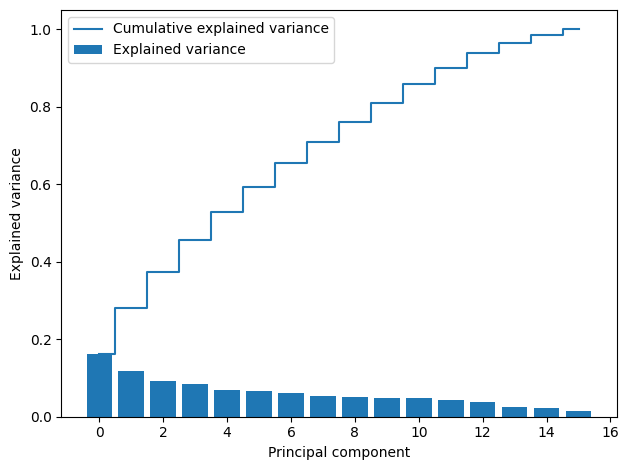

In [7]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, align='center', label='Explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Застосуємо PCA, щоб знизити розмірність

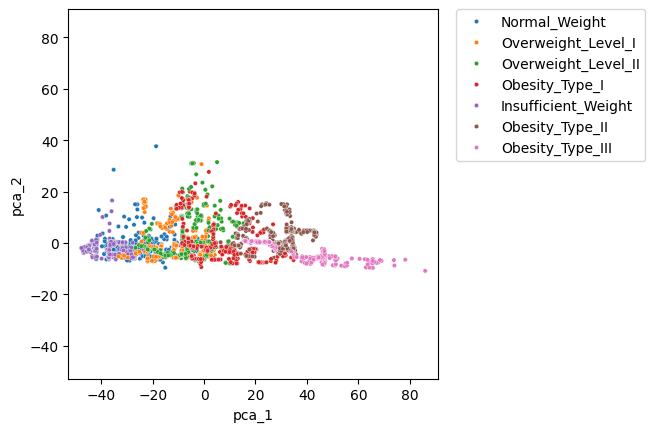

In [8]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=10)
lim = (pca_result.min()-5, pca_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Для візуалізації також можемо скористатися методом tSNE

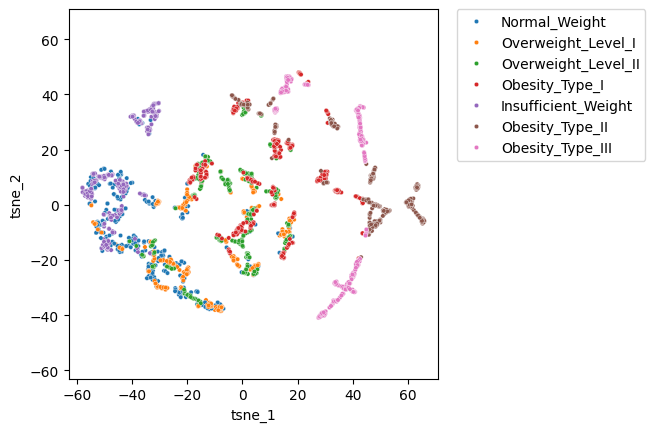

In [ ]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## Завдання 2: Кластерний аналіз

In [ ]:
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

### Завантажимо зображення та "заскейлимо RGB" значення на проміжок [0, 1]

In [ ]:
image = Image.open('data/cyberpunk_city.jpg')
image_data_scaled = np.array(image, dtype=np.float64) / 255

In [ ]:
# Display all results, alongside original image
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(image_data_scaled)

### Зведемо зобранження у двовимірний масив для застосування K-Means

In [ ]:
w, h, d = original_shape = tuple(image_data_scaled.shape)
assert d == 3
image_array = np.reshape(image_data_scaled, (w * h, d))

### Стискання за допомогою K-Means до 64 кольорів

In [ ]:
n_colors = 64

image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

### Стискання за допомогою K-Means до 32 кольорів

In [ ]:
n_colors = 32

image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

### Стискання за допомогою K-Means до 16 кольорів

In [ ]:
n_colors = 16

image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

### Стискання за допомогою K-Means до 8 кольорів

In [ ]:
n_colors = 8

image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

## Завдання 3: Обробка та класифікація текстових даних

In [ ]:
from nltk import download
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re

download('stopwords')

def clean_line(line, stop_words):
    """Clean text from numbers, punctuation and stop words"""
    line = line.lower()
    line = re.sub(r'@\S+', ' ', line)
    line = re.sub(r'https*\S+', ' ', line)
    line = re.sub(r'#\S+', ' ', line)
    line = re.sub(r'\d', ' ', line)
    line = re.sub(r'[%s]' % re.escape(punctuation), ' ', line)
    line = re.sub(r'\n', ' ', line)
    line = re.sub(r'\s{2,}',' ', line)
    line = ' '.join([token for token in line.split(' ') if token not in stop_words])
    return line

### Вибір датасету

Для цього завдання було обрано датасет відгуків про додаток Spotify з Google Play Store за проміжок Січня-Липня 2022 року. Датасет містить текст відгуку та мітку позитивний/негативний (емоційне забарвлення).

Посилання: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset

Проведемо загальний огляд датасету.

In [ ]:
df_spotify = pd.read_csv('data/SpotifyReviews.csv')
df_spotify = df_spotify.dropna()

df_spotify.info()

In [ ]:
df_spotify.shape

In [ ]:
TEXT_COLUMN_NAME = df_spotify.columns[0]
LABEL_COLUMN_NAME = df_spotify.columns[1]

df_spotify.columns

In [ ]:
df_spotify.head()

In [ ]:
from collections import Counter
Counter(df_spotify[LABEL_COLUMN_NAME])

### Очистимо тексти відгуків від пунктуації, чисел та загальних для мови неінформативних слів

In [ ]:
stop_words = stopwords.words('english')
df_spotify['Review'] = df_spotify['Review'].map(lambda line: clean_line(line, stop_words))

In [ ]:
df_spotify.head()

### Візуалізація: зобразимо для обох класів Хмари Слів

In [ ]:
from wordcloud import WordCloud

def create_wordcloud(data_frame, label):
    text = ''
    for msg in data_frame[data_frame[LABEL_COLUMN_NAME] == label][TEXT_COLUMN_NAME]:
        msg = msg.lower()
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Word cloud for \'{label}\'')
    plt.show()

In [ ]:
for label in set(df_spotify['label']):
    create_wordcloud(df_spotify, label)

### Розіб'ємо датасет на тренувальні дані та дані для перевірки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_spotify[TEXT_COLUMN_NAME], df_spotify[LABEL_COLUMN_NAME], test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)

### Векторизуємо дані за допомогою TfidfVectorizer

Таким чином перетворимо декстові дані в оцінку та підготуємо дані для тренування моделі.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=6.0)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Модель 1: Наївний баєсів класифікатор

In [ ]:
from sklearn.naive_bayes import MultinomialNB

Підберемо параметр згладжування, що дасть найменшу помилку. Це не є обов'язковим, але було цікаво подивитися :D

In [ ]:
error_rate = {}

for a in [x / 10.0 for x in range(1, 20, 1)]:
    nb_trial = MultinomialNB(alpha=a)
    nb_trial.fit(X_train, y_train)
    pred_a = nb_trial.predict(X_test)
    error_rate[a] = (np.mean(pred_a != y_test))

In [ ]:
alph = min(error_rate, key=error_rate.get)
alph, error_rate[alph]

Навчання та застосування моделі до тестового набору даних.

In [ ]:
classifier_nb = MultinomialNB(alpha=alph)
classifier_nb.fit(X_train, y_train)

naive_bayes_predict = classifier_nb.predict(X_test)

In [ ]:
print(classification_report(y_test, naive_bayes_predict))
print(confusion_matrix(y_test, naive_bayes_predict))

### Модель 2: Логістична Регресія

Ця модель застосовна, так як наші дані мають "бінарні мітки". Іншими словами, їх можна замінити на 0 і 1.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

lr_predict = classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, lr_predict))
print(confusion_matrix(y_test, lr_predict))